# Interpretability Study - Assault

### Import

In [1]:
import os
import sys
from copy import deepcopy
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import cv2
import PIL
from PIL import Image
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt

import torch as th
from torch import nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid, save_image

import gym as gym26
import gymnasium as gym
from gymnasium import spaces
from gymnasium.spaces import Box, Discrete
import stable_baselines3 as sb3
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3 import A2C, DDPG, DQN, PPO, SAC, TD3
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env, make_atari_env
from stable_baselines3.common.preprocessing import is_image_space, is_image_space_channels_first
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecEnv, VecFrameStack, VecNormalize, VecTransposeImage, is_vecenv_wrapped
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule

### Set configs

In [5]:
game = 'AssaultNoFrameskip-v4'
n_envs = 1
seed = 0
DEVICE = "cpu"
CHECKPOINT_EXT = "model_checkpoint_6000000_steps"
GAME_VERSION = "NoFrameskip-v4"
game_no_version = game.replace(GAME_VERSION, '')

# self-attention type and seed in each model checkpoint file
sat_to_seed_mapping = {
    'SWA': 0,
    'CWRA': 42,
    'NA': 42,
    'CWRCA': 1234,
    'CWCA': 1,
}

# winner at the leftmost, follow by runner-up, second runner-up, and so on
sat_list = ['SWA', 'CWRA', 'NA', 'CWRCA', 'CWCA']

# path to observation files and model checkpoints
path = f'model/{game_no_version}/'

### Create & wrap the game env

In [ ]:
vec_env = make_atari_env(game, n_envs=n_envs, seed=seed)
vec_env = VecFrameStack(vec_env, n_stack=4)

wrap_with_vectranspose = is_image_space(vec_env.observation_space) and not is_image_space_channels_first(vec_env.observation_space)
# wrap the vec_env with VecTransposeImage if wrap_with_vectranspose is True
if wrap_with_vectranspose:
    vec_env = VecTransposeImage(vec_env)
else:
    warnings.warn("VecTransposeImage is not applied.")

### Check saved observations

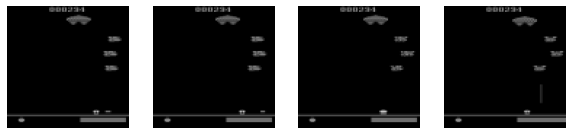

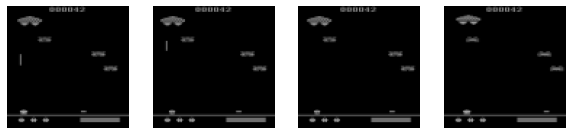

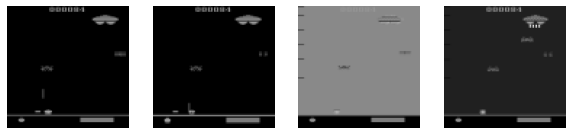

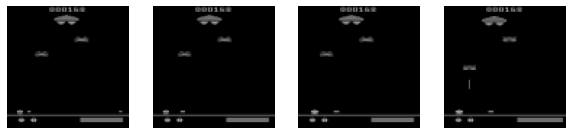

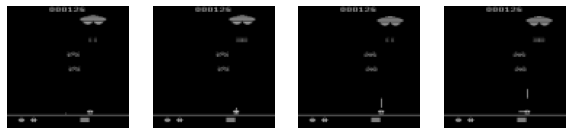

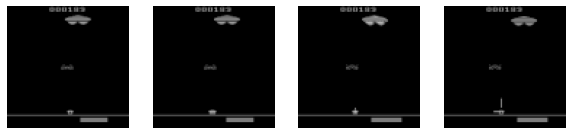

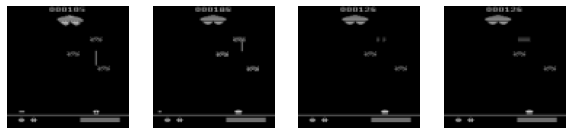

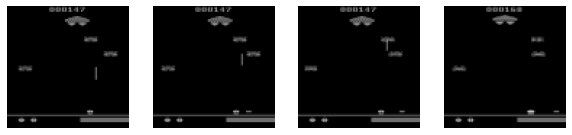

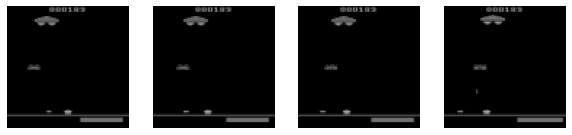

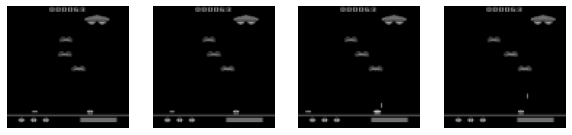

In [56]:
for idx in range(10):
    with open(f'{path}{game_no_version}_obs_{idx+1}.npy', 'rb') as f:
        obs = np.load(f)
        fig = plt.figure(idx, figsize=(10,4))
        for pos, frame in enumerate(obs.squeeze()):
            ax = fig.add_subplot(1, 4, pos+1)
            plt.imshow(frame, cmap='gray', vmin=0, vmax=255)
            plt.axis('off')
        plt.show()

### Define the feature extractor class

We copy the classes definitions from the `/home/JIANXIAO001/SB3_Zoo3/rl-baselines3-zoo/rl_zoo3/utils.py`

In [57]:
class SelfAttnCNNPPO(BaseFeaturesExtractor):
    """
    Define our custom feature extractor (note: this is only the state representation block of the Actor-Critic network)
    For the CNN network here, we are following the PPO paper's setup.
    Note that the PPO paper follows the network architecture used in the both papers below.
    “Asynchronous methods for deep reinforcement learning”. In: arXiv preprint arXiv:1602.01783 (2016).
    "Playing atari with deep reinforcement learning". In NIPS Deep Learning Workshop. 2013.

    :param observation_space: (gym.Space) gym.spaces.Box
        This should be in the format of channel-first since the observation is an image for Atari envs.
    :param features_dim: (int) Number of features extracted (e.g. features from a CNN). default: 256 (follows the PPO paper)
        This corresponds to the number of unit for the last layer of the feature extractor.
        The last layer of feature extractor is also the first layer (input layer) of the net_arch block.
        We can also change the hidden layers of the net_arch by passing the net_arch parameter to policy_kwargs. 
        net_arch specifies a (fully-connected) network that maps the features to actions/value. Its architecture is controlled by the ``net_arch`` parameter.
        For more details, please visit https://github.com/DLR-RM/stable-baselines3/blob/378d197b00938579a6a5e04c739f41fec23fd805/docs/guide/custom_policy.rst
    :param self_attn: (str) Type of self-attention layer, default: 'NA' = No-Self-Attention. 
    :param ada_attn: (str) Type of adaptive attention configuration, default: None
    :param norm_softmax: (bool) Flag for whether normalization and softmax will be performed. default: True
        Here we follow the standard "Transformer"'s' self-attention definition. 
    """
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int=256, self_attn: str='NA', ada_attn: str=None, norm_softmax: bool=True):
        super(SelfAttnCNNPPO, self).__init__(observation_space, features_dim)
        self.observation_space = observation_space
        self.n_input_channels = observation_space.shape[0]
        self.self_attn = self_attn
        self.ada_attn = ada_attn
        self.norm_softmax = norm_softmax
        if self.self_attn is not None:
            if self.self_attn != 'NA':
                print("{} self-attention layer will be added.".format(self.self_attn))
                self.self_attn_layer = MultiHeadAttention(size=16, self_attn=self.self_attn, ada_attn=self.ada_attn, norm_softmax=self.norm_softmax)
            else:
                print("No self-attention layer will be added.")
            self.c1 = nn.Conv2d(self.n_input_channels, 16, 8, stride=4)
            self.c2 = nn.Conv2d(16, 32, 4, stride=2)
            self.n_flatten = self._get_flatten_size(self.observation_space.shape) 
            self.l1 = nn.Linear(self.n_flatten, features_dim) 
        else:
            sys.exit("self_attn argument must not be None! Please choose one from ['NA', 'SWA', 'CWRA', 'CWCA', 'CWRCA']")

    def custom_cnn_block(self, observations: th.Tensor) -> th.Tensor:
        h = F.relu(self.c1(observations))
        if self.self_attn != 'NA':
            h = self.self_attn_layer(h) 
        h = F.relu(self.c2(h)) 
        return h

    def _get_flatten_size(self, obs_shape: Tuple) -> int:
        with th.no_grad():
            x = th.zeros(1, *obs_shape) 
            h = self.custom_cnn_block(x) 
            return int(np.prod(h.size())) 

    def custom_feature_extractor(self, observations: th.Tensor) -> th.Tensor:
        h = self.custom_cnn_block(observations)
        h = h.reshape(-1).view(-1, self.n_flatten)
        h = F.relu(self.l1(h))
        return h

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.custom_feature_extractor(observations)


class MultiHeadAttention(nn.Module):
    """
    Define the multi-head attention block (we define 4 types of self-attention operations based on the feature dimensions selected for performing self-attention upon)
        'SWA': spatial-wise self-attention
        'CWRA': channel-wise-row self-attention
        'CWCA': channel-wise-column self-attention 
        'CWRCA': channel-wise-row-column self-attention
    """
    def __init__(self, size=16, self_attn=None, ada_attn=None, norm_softmax=True):
        super().__init__()
        self.size = size
        self.self_attn = self_attn
        assert self.self_attn is not None, "self_attn type cannot be None in multi-head attention block!"
        self.ada_attn = ada_attn
        self.norm_softmax = norm_softmax

        self.w_qs = nn.Conv2d(size, size, 1)
        self.w_ks = nn.Conv2d(size, size, 1)
        self.w_vs = nn.Conv2d(size, size, 1)

        if self.self_attn == 'SWA':
            self.self_attention = SpatialWiseAttention(require_scaling=self.norm_softmax)
        if self.self_attn == 'CWRA':
            self.self_attention = ChannelWiseRowAttention(require_scaling=self.norm_softmax)
        if self.self_attn == 'CWCA':
            self.self_attention = ChannelWiseColumnAttention(require_scaling=self.norm_softmax)
        if self.self_attn == 'CWRCA':
            self.self_attention = ChannelWiseRowColumnAttention(require_scaling=self.norm_softmax)

        # for adaptive attention
        self.alpha = th.nn.Parameter(th.zeros(1))
        self.beta = th.nn.Parameter(th.ones(1)) 

    def forward(self, h: th.Tensor) -> th.Tensor:
        cnn_features = h 
        q = self.w_qs(h)
        k = self.w_ks(h)
        v = self.w_vs(h) 

        attention = self.self_attention(q, k, v)

        if self.ada_attn is not None:
            if self.ada_attn == 'alpha':
                out = self.alpha*attention + cnn_features
            if self.ada_attn == 'beta':
                out = attention + self.beta*cnn_features
            if self.ada_attn == 'alpha_beta':
                out = self.alpha*attention + self.beta*cnn_features
        else:
            out = attention + cnn_features
        return out


class SpatialWiseAttention(nn.Module):
    """
    Perform self-attention on spatial dimensions (column and row), no permutation of q,k,v dimensions where q, k, v are of size (N, C, H, W) 
    """
    def __init__(self, require_scaling=True):
        super().__init__()
        self.require_scaling = require_scaling
        if self.require_scaling:
            self.SWA = ScaledDotProductAttention()
        else:
            self.SWA = DotProductAttention()

    def forward(self, q, k, v):
        if self.require_scaling:
            n = k.shape[-1]
            output = self.SWA(q, k, v, n)
        else:
            output = self.SWA(q, k, v)
        
        return output


class ChannelWiseRowAttention(nn.Module):
    """
    Perform self-attention on channel and row dimensions, permutation of q,k,v dimensions: (N, C, H, W) --> (N, W, H, C) 
    """
    def __init__(self, require_scaling=True):
        super().__init__()
        self.require_scaling = require_scaling
        if self.require_scaling:
            self.CWRA = ScaledDotProductAttention()
        else:
            self.CWRA = DotProductAttention()

    def forward(self, q, k, v):
        # permute dimensions so that the last 2 dims of q,k,v are (H,C)=(row, channel)
        q = q.permute(0, 3, 2, 1)
        k = k.permute(0, 3, 2, 1)
        v = v.permute(0, 3, 2, 1)

        if self.require_scaling:
            n = k.shape[-1]
            output = self.CWRA(q, k, v, n)
        else:
            output = self.CWRA(q, k, v)
        
        return output.permute(0, 3, 2, 1) # we need to convert (N, W, H, C) back to (N, C, H, W) before adding it to the cnn_features


class ChannelWiseColumnAttention(nn.Module):
    """
    Perform self-attention on channel and column dimensions, permutation of q,k,v dimensions: (N, C, H, W) --> (N, H, W, C) 
    """
    def __init__(self, require_scaling=True):
        super().__init__()
        self.require_scaling = require_scaling
        if self.require_scaling:
            self.CWCA = ScaledDotProductAttention()
        else:
            self.CWCA = DotProductAttention()

    def forward(self, q, k, v):
        # permute dimensions so that the last 2 dims of q,k,v are (W,C)=(column, channel)
        q = q.permute(0, 2, 3, 1)
        k = k.permute(0, 2, 3, 1)
        v = v.permute(0, 2, 3, 1)

        if self.require_scaling:
            n = k.shape[-1]
            output = self.CWCA(q, k, v, n)
        else:
            output = self.CWCA(q, k, v)
        
        return output.permute(0, 3, 1, 2) # we need to convert (N, H, W, C) back to (N, C, H, W) before adding with cnn_features


class ChannelWiseRowColumnAttention(nn.Module):
    """
    Combine self-attention performed on both channel-row and channel-column dimensions 
    permutation of q,k,v dimensions: (N, C, H, W) --> (N, W, H, C) 
    permutation of q,k,v dimensions: (N, C, H, W) --> (N, H, W, C) 
    """
    def __init__(self, require_scaling=True):
        super().__init__()
        self.require_scaling = require_scaling
        if self.require_scaling:
            self.CWRA = ScaledDotProductAttention()
            self.CWCA = ScaledDotProductAttention()
        else:
            self.CWRA = DotProductAttention()
            self.CWCA = DotProductAttention()

    def forward(self, q, k, v):
        # permute dimensions so that the last 2 dims of q,k,v are (H,C)=(row, channel)
        q_r = q.permute(0, 3, 2, 1)
        k_r = k.permute(0, 3, 2, 1)
        v_r = v.permute(0, 3, 2, 1)
        # permute dimensions so that the last 2 dims of q,k,v are (W,C)=(column, channel)
        q_c = q.permute(0, 2, 3, 1)
        k_c = k.permute(0, 2, 3, 1)
        v_c = v.permute(0, 2, 3, 1)

        if self.require_scaling:
            n = k.shape[-1] 
            output_r = self.CWRA(q_r, k_r, v_r, n).permute(0, 3, 2, 1) # convert back to (N, C, H, W)
            output_c = self.CWCA(q_c, k_c, v_c, n).permute(0, 3, 1, 2) # convert back to (N, C, H, W)
        else:
            output_r = self.CWRA(q_r, k_r, v_r).permute(0, 3, 2, 1) # convert back to (N, C, H, W)
            output_c = self.CWCA(q_c, k_c, v_c).permute(0, 3, 1, 2) # convert back to (N, C, H, W)
        
        return output_r + output_c


class DotProductAttention(nn.Module):
    """
    Perform dot product attention (without normalization and softmax)
    """
    def __init__(self):
        super().__init__()

    def forward(self, q, k, v):
        attn = th.matmul(q, k.transpose(2, 3))
        output = th.matmul(attn, v)
        return output


class ScaledDotProductAttention(nn.Module):
    """
    Perform scaled dot product attention (with normalization and softmax)
    """
    def __init__(self):
        super().__init__()

    def forward(self, q, k, v, n):
        attn = th.matmul(q, k.transpose(2, 3))
        normed_attn = attn / sqrt(n)
        scaled_attn = F.softmax(normed_attn, dim=-1)
        output = th.matmul(scaled_attn, v)
        return output

### Visualization utilities

In [149]:
def convert_to_heatmap(input_tensor: th.Tensor):
    """Make heatmap from a torch tensor. The input_tensor needs to be normalized and have H, W dimension after squeezing.
    Args:
        input_tensor (torch.tensor): shape of (1, 1, H, W) and each element has value in range [0, 1]

    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
    """
    heatmap = (255 * input_tensor.squeeze()).type(th.uint8).cpu().numpy()
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = th.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = th.cat([r, g, b])

    return heatmap

In [151]:
class Interpretability:
    """Forward and backward hooks
    """

    def __init__(self, arch: torch.nn.Module, target_layer: torch.nn.Module, sat: str=None):
        """
        :param arch: e.g., model.policy
        :param target_layer: e.g., model.policy.features_extractor.c1
        """
        assert sat is not None, f"sat must be given, use one of 'NA', 'SWA', 'CWRA', 'CWCA', 'CWRCA'!"
        self.model_arch = arch
            
        self.activations_sb3 = {}
        def get_activation(name):
            def hook(model, input, output):
                self.activations_sb3[name] = output
            return hook

        self.model_arch.action_net.register_forward_hook(get_activation('action_net')) #forward hook of the action_net layer (action logits)
        self.model_arch.features_extractor.c1.register_forward_hook(get_activation('c1')) #forward hook of the c1 layer (c1 feature maps)
        self.model_arch.features_extractor.c2.register_forward_hook(get_activation('c2')) #forward hook of the c2 layer (c2 feature maps)
        
        if sat != 'NA':
            self.model_arch.features_extractor.self_attn_layer.register_forward_hook(get_activation('self_attn_layer')) #forward hook of the self_attn_layer layer (attended feature maps)
            self.model_arch.features_extractor.self_attn_layer.self_attention.register_forward_hook(get_activation('self_attention')) #forward hook of the self_attention layer (raw attention maps)
        
        self.gradients = dict()
        self.activations = dict()

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0] # stores back-propagated gradients of the target layer

        def forward_hook(module, input, output):
            self.activations['value'] = output # stores feed-forward feature maps of the target layer

        target_layer.register_forward_hook(forward_hook) # register forward hook for target layer
        target_layer.register_full_backward_hook(backward_hook) # register backward hook for target layer

    def forward(self, input, deterministic=None, retain_graph=False):
        assert deterministic is not None, f"'deterministic' must be set to either True or False!"
        b, c, h, w = input.size()

        action, value, action_log_prob = self.model_arch(input, deterministic=deterministic) 
        attended_feature_maps = self.activations_sb3.get('self_attn_layer') 
        logit = self.activations_sb3.get('action_net') 
        assert logit is not None, f"action_net output cannot be None!"
        score = logit[:, action].squeeze()
        c1_feature_maps = self.activations_sb3.get('c1') 
        c2_feature_maps = self.activations_sb3.get('c2') 
        attention_maps = self.activations_sb3.get('self_attention')

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value'] 
        b, k, u, v = gradients.size() # b=batch, k=kernel=channel, u=height of the kernel, v=width of the kernel

        # compute weights
        alpha = gradients.view(b, k, -1).mean(2) 
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map) 
        saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False) 
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max() # normalize saliency map
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

        return saliency_map, action, value, logit, score, gradients, activations, attended_feature_maps, c1_feature_maps, c2_feature_maps, attention_maps

    def __call__(self, input, deterministic=None, retain_graph=False):
        return self.forward(input, deterministic, retain_graph)

### Generate all visualizations

In [153]:
gradcams_all = [] # gradcam of the target layer
actions_all = [] # actions selected by the agent (depends on deterministic parameter)
values_all = [] # value_net output
logits_all = [] # action_net outputs
scores_all = [] # logits selected based on actions
gradients_all = [] # gradients of the target layer
activations_all = [] # feed-forward output of the target layer
attended_feature_maps_all = [] # self_attn_layer outputs
c1_feature_maps_all = [] # rectified c1 feature maps (after passing ReLU)
c2_feature_maps_all = [] # rectified c2 feature maps (after passing ReLU)
attention_maps_all = [] # attention maps

h = 84
w = 84
deterministic = True

# each row holds all heatmaps for an obs 
# each column is an sat model
for obs_idx in range(10):
    # load observation .npy file
    with open(f'{path}{game_no_version}_obs_{obs_idx+1}.npy', 'rb') as f:
        obs = np.load(f)
    # convert observation to torch tensor
    obs_th = th.FloatTensor(obs)
    gradcams_per_obs = []
    actions_per_obs = []
    values_per_obs = []
    logits_per_obs = []
    scores_per_obs = []
    gradients_per_obs = []
    activations_per_obs = []
    attended_feature_maps_per_obs = []
    c1_feature_maps_per_obs = [] # rectified c1 feature maps per obs (after passing ReLU)
    c2_feature_maps_per_obs = [] # rectified c2 feature maps per obs (after passing ReLU)
    attention_maps_per_obs = []
    for sat in sat_list:
        # instantiate the PPO model
        policy_kwargs = eval(f"dict(features_extractor_class=SelfAttnCNNPPO, features_extractor_kwargs=dict(self_attn='{sat}'), net_arch=[])")
        model = PPO(policy='CnnPolicy', env=vec_env, seed=seed, verbose=True, device=DEVICE, policy_kwargs=policy_kwargs) # seed is the env's seed set at the beginning
        # update the model by loading the selected checkpoint zip file
        # get seed used in the model checkpoint file
        seed_checkpoint = sat_to_seed_mapping.get(sat)
        model_updated = model.load(f"{path}{game_no_version}_{sat}_{seed_checkpoint}_{CHECKPOINT_EXT}", device=DEVICE, print_system_info=True)
        # get the policy and the target layer
        policy = model_updated.policy
        target_layer = policy.features_extractor.c1
        interpreter = Interpretability(policy, target_layer, sat=sat)
        saliency_map, action, value, logit, score, gradients, activations, attended_feature_maps, c1_feature_maps, c2_feature_maps, attention_maps = interpreter(obs_th, deterministic=deterministic)
        # convert saliency map to heatmap
        heatmap = convert_to_heatmap(saliency_map)
        gradcams_per_obs.extend([heatmap])
        actions_per_obs.extend([action])
        values_per_obs.extend([value])
        logits_per_obs.extend([logit])
        scores_per_obs.extend([score])
        gradients_per_obs.extend([gradients])
        activations_per_obs.extend([activations])
        # preprocess attended_feature_maps before converting to headmap style
        if attended_feature_maps is not None:
            attended_feature_maps_sum = attended_feature_maps.sum(1, keepdim=True) # shape=(1, 1, 20, 20)
            attended_feature_maps_upsample = F.interpolate(attended_feature_maps_sum, size=(h,w), mode='bilinear', align_corners=False) # upsample to input size (1, 1, 84, 84)
            attended_feature_maps_upsample_min, attended_feature_maps_upsample_max = attended_feature_maps_upsample.min(), attended_feature_maps_upsample.max() # get min and max
            attended_feature_maps_norm = (attended_feature_maps_upsample - attended_feature_maps_upsample_min).div(attended_feature_maps_upsample_max - attended_feature_maps_upsample_min).data
            # convert to heatmap style (color)
            attended_feature_maps_color = convert_to_heatmap(attended_feature_maps_norm)
            attended_feature_maps_per_obs.extend([attended_feature_maps_color])
        # preprocess c1_feature_maps before converting to headmap style
        c1_feature_maps = F.relu(c1_feature_maps) # rectified c1 feature maps
        c1_feature_maps_sum = c1_feature_maps.sum(1, keepdim=True) # shape=(1, 1, 20, 20)
        c1_feature_maps_upsample = F.interpolate(c1_feature_maps_sum, size=(h,w), mode='bilinear', align_corners=False) # upsample to input size (1, 1, 84, 84)
        c1_feature_maps_upsample_min, c1_feature_maps_upsample_max = c1_feature_maps_upsample.min(), c1_feature_maps_upsample.max() # get min and max
        c1_feature_maps_norm = (c1_feature_maps_upsample - c1_feature_maps_upsample_min).div(c1_feature_maps_upsample_max - c1_feature_maps_upsample_min).data
        # convert to heatmap style (color)
        c1_feature_maps_color = convert_to_heatmap(c1_feature_maps_norm)
        c1_feature_maps_per_obs.extend([c1_feature_maps_color])
        # preprocess c2_feature_maps before converting to headmap style
        c2_feature_maps = F.relu(c2_feature_maps) # rectified c2 feature maps
        c2_feature_maps_sum = c2_feature_maps.sum(1, keepdim=True) # shape=(1, 1, 9, 9)
        c2_feature_maps_upsample = F.interpolate(c2_feature_maps_sum, size=(h,w), mode='bilinear', align_corners=False) # upsample to input size (1, 1, 84, 84)
        c2_feature_maps_upsample_min, c2_feature_maps_upsample_max = c2_feature_maps_upsample.min(), c2_feature_maps_upsample.max() # get min and max
        c2_feature_maps_norm = (c2_feature_maps_upsample - c2_feature_maps_upsample_min).div(c2_feature_maps_upsample_max - c2_feature_maps_upsample_min).data
        # convert to heatmap style (color)
        c2_feature_maps_color = convert_to_heatmap(c2_feature_maps_norm)
        c2_feature_maps_per_obs.extend([c2_feature_maps_color])
        # preprocess attention_maps before converting to headmap style
        if attention_maps is not None:
            attention_maps_sum = attention_maps.sum(1, keepdim=True) # shape=(1, 1, 20, 20)
            attention_maps_upsample = F.interpolate(attention_maps_sum, size=(h,w), mode='bilinear', align_corners=False) # upsample to input size (1, 1, 84, 84)
            attention_maps_upsample_min, attention_maps_upsample_max = attention_maps_upsample.min(), attention_maps_upsample.max() # get min and max
            attention_maps_norm = (attention_maps_upsample - attention_maps_upsample_min).div(attention_maps_upsample_max - attention_maps_upsample_min).data
            # convert to heatmap style (color)
            attention_maps_color = convert_to_heatmap(attention_maps_norm)
            attention_maps_per_obs.extend([attention_maps_color])
        
    gradcams_all.extend(gradcams_per_obs)
    actions_all.extend(actions_per_obs)
    values_all.extend(values_per_obs)
    logits_all.extend(logits_per_obs)
    scores_all.extend(scores_per_obs)
    gradients_all.extend(gradients_per_obs)
    activations_all.extend(activations_per_obs)
    attended_feature_maps_all.extend(attended_feature_maps_per_obs)
    c1_feature_maps_all.extend(c1_feature_maps_per_obs) # rectified c1 feature maps (after passing ReLU)
    c2_feature_maps_all.extend(c2_feature_maps_per_obs) # rectified c2 feature maps (after passing ReLU)
    attention_maps_all.extend(attention_maps_per_obs)

Using cpu device
SWA self-attention layer will be added.
== CURRENT SYSTEM INFO ==
- OS: Linux-5.15.0-33-generic-x86_64-with-glibc2.29 # 34~20.04.1-Ubuntu SMP Thu May 19 15:51:16 UTC 2022
- Python: 3.8.5
- Stable-Baselines3: 2.0.0
- PyTorch: 1.13.0+rocm5.2
- GPU Enabled: True
- Numpy: 1.22.4
- Cloudpickle: 2.2.1
- Gymnasium: 0.28.1
- OpenAI Gym: 0.26.2

== SAVED MODEL SYSTEM INFO ==
- OS: Linux-5.4.0-26-generic-x86_64-with-glibc2.29 # 30-Ubuntu SMP Mon Apr 20 16:58:30 UTC 2020
- Python: 3.8.5
- Stable-Baselines3: 2.0.0
- PyTorch: 1.13.0+rocm5.2
- GPU Enabled: True
- Numpy: 1.22.4
- Cloudpickle: 2.2.1
- Gymnasium: 0.28.1
- OpenAI Gym: 0.26.2

SWA self-attention layer will be added.
Using cpu device
CWRA self-attention layer will be added.
== CURRENT SYSTEM INFO ==
- OS: Linux-5.15.0-33-generic-x86_64-with-glibc2.29 # 34~20.04.1-Ubuntu SMP Thu May 19 15:51:16 UTC 2022
- Python: 3.8.5
- Stable-Baselines3: 2.0.0
- PyTorch: 1.13.0+rocm5.2
- GPU Enabled: True
- Numpy: 1.22.4
- Cloudpickle: 2

#### rectified c1 feature maps ($F_1$)

In [155]:
grid_image_c1_feature_map = make_grid(c1_feature_maps_all, nrow=5)
grid_image_c1_feature_map_PIL = transforms.ToPILImage()(grid_image_c1_feature_map)

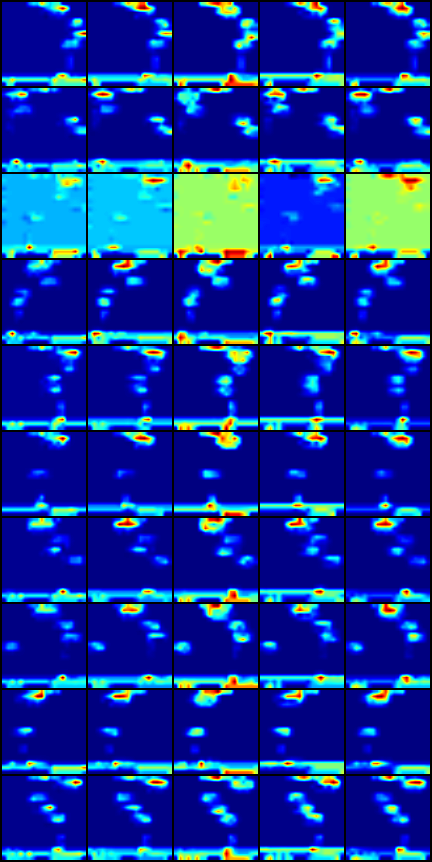

In [156]:
grid_image_c1_feature_map_PIL

In [157]:
# grid_image_c1_feature_map_PIL.save(f"{path}{game_no_version}_rectified_c1_feature_map.pdf")

#### Attention map ($\hat{Y}$)

In [203]:
grid_image_attention_map = make_grid(attention_maps_all, nrow=4)
grid_image_attention_map_PIL = transforms.ToPILImage()(grid_image_attention_map)

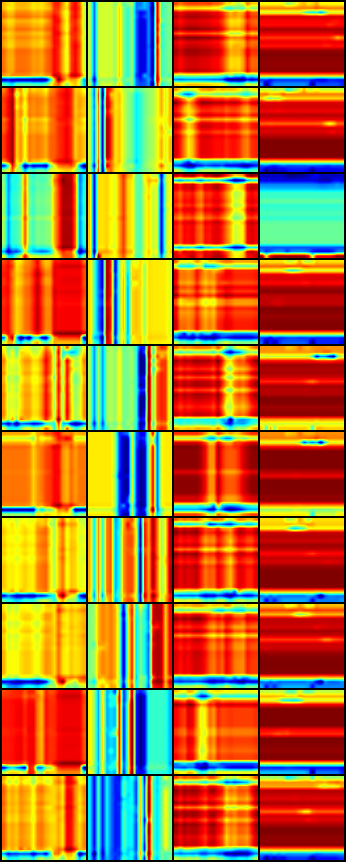

In [204]:
grid_image_attention_map_PIL

In [205]:
# grid_image_attention_map_PIL.save(f"{path}{game_no_version}_attention_map.pdf")

#### Attended feature map ($\hat{F_1}$)

In [207]:
grid_image_attended_feature_map = make_grid(attended_feature_maps_all, nrow=4)
grid_image_attended_feature_map_PIL = transforms.ToPILImage()(grid_image_attended_feature_map)

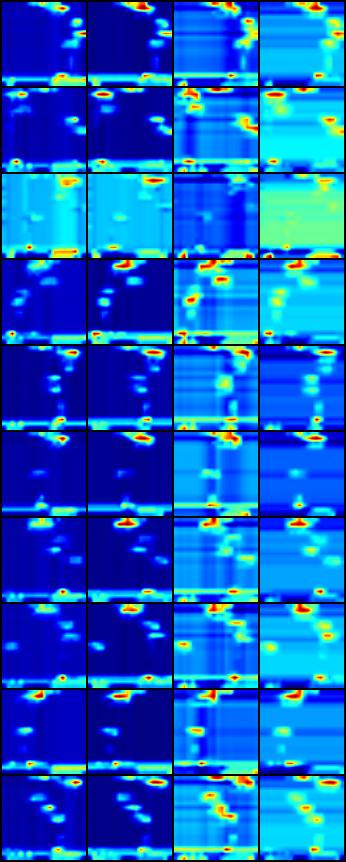

In [208]:
grid_image_attended_feature_map_PIL

In [209]:
# grid_image_attended_feature_map_PIL.save(f"{path}{game_no_version}_attended_feature_map.pdf")

#### rectified c2 feature maps ($F_2$)

In [211]:
grid_image_c2_feature_map = make_grid(c2_feature_maps_all, nrow=5)
grid_image_c2_feature_map_PIL = transforms.ToPILImage()(grid_image_c2_feature_map)

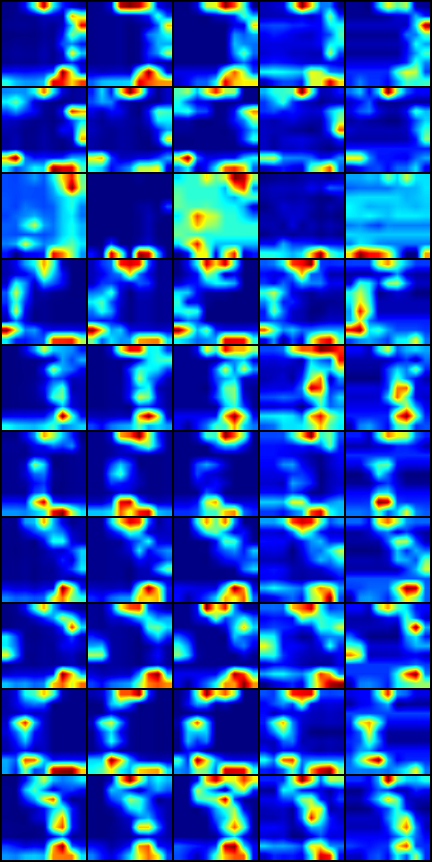

In [212]:
grid_image_c2_feature_map_PIL

In [213]:
# grid_image_c2_feature_map_PIL.save(f"{path}{game_no_version}_rectified_c2_feature_map.pdf")